[View in Colaboratory](https://colab.research.google.com/github/webserg/pythonML/blob/master/plankton.ipynb)

https://www.kaggle.com/c/datasciencebowl/data
http://benanne.github.io/2015/03/17/plankton.html


In [2]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [5]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11322            True  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5393           False  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2510           False  


In [6]:
!pwd

/content


In [0]:
!mkdir datasciencebowl

In [13]:
!ls -l

total 12
drwxr-xr-x 1 root root 4096 May 18 19:47 datalab
drwxr-xr-x 2 root root 4096 May 18 19:53 datasciencebowl
drwxr-xr-x 2 root root 4096 May 18 19:54 plankton


In [10]:
!kaggle competitions download -c datasciencebowl -p ./plankton

sampleSubmission.csv.zip: Downloaded 886KB of 886KB to ./plankton
train.zip: Downloaded 76MB of 76MB to ./plankton
test.zip: Downloaded 347MB of 347MB to ./plankton
plankton_identification.pdf: Downloaded 2MB of 2MB to ./plankton


In [16]:
%cd ./plankton/

/content/plankton


In [20]:
%ls -l

total 435468
-rw-r--r--   1 root root   1621177 May 18 19:54 plankton_identification.pdf
-rw-r--r--   1 root root    907443 May 18 19:54 sampleSubmission.csv.zip
-rw-r--r--   1 root root 363454024 May 18 19:54 test.zip
drwxr-xr-x 123 root root      4096 May 18 20:00 train/
-rw-r--r--   1 root root  79921404 May 18 19:54 train.zip


In [18]:
import zipfile
import os
data_dir = "/content/plankton"
path_to_data = "/content/plankton/train.zip"
path_to_data

'/content/plankton/train.zip'

In [0]:
if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)

In [0]:
zip_ref = zipfile.ZipFile(path_to_data, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [0]:
path_to_test = os.getenv("HOME") + "/.kaggle/competitions/datasciencebowl/test.zip"
path_to_test

'C:\\Users\\webse/.kaggle/competitions/datasciencebowl/test.zip'

In [0]:
zip_ref = zipfile.ZipFile(path_to_test, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [0]:
validation_dir = os.path.join(data_dir, 'validation')
if os.path.exists(validation_dir) == False:
    os.mkdir(validation_dir)

In [0]:
import shutil
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [23]:
validation_dir = os.path.join(data_dir, 'validation')

dir_info = [x for x in os.walk(train_dir)]
for dir in dir_info[1:]:
    print(len(dir[2]))
    validation_number = int(round(len(dir[2])/10))
    print(validation_number)
    print(dir[2])
    print(dir[2][:validation_number])
    dir_name = os.path.split(dir[0])[1]
    print(dir_name)
    validation_dir_current = os.path.join(validation_dir, dir_name)
    if os.path.exists(validation_dir_current) == False:
        os.mkdir(validation_dir_current)
    for fname in dir[2][:validation_number]:
        src = os.path.join(train_dir, dir_name, fname)
        dst = os.path.join(validation_dir_current, fname)
        print(src)
        print(dst)
        shutil.move(src, dst)


10
1
['5902.jpg', '61180.jpg', '85811.jpg', '52638.jpg', '153969.jpg', '63766.jpg', '52035.jpg', '132687.jpg', '106185.jpg', '160696.jpg']
['5902.jpg']
heteropod
/content/plankton/train/heteropod/5902.jpg
/content/plankton/validation/heteropod/5902.jpg
170
17
['78930.jpg', '3534.jpg', '17122.jpg', '88748.jpg', '141185.jpg', '44281.jpg', '41782.jpg', '85337.jpg', '76028.jpg', '7710.jpg', '89210.jpg', '53465.jpg', '32153.jpg', '107132.jpg', '152589.jpg', '113419.jpg', '133708.jpg', '22682.jpg', '52344.jpg', '6697.jpg', '107327.jpg', '149017.jpg', '22975.jpg', '97228.jpg', '22620.jpg', '29625.jpg', '159866.jpg', '119933.jpg', '23386.jpg', '2112.jpg', '29877.jpg', '113307.jpg', '22483.jpg', '89330.jpg', '24283.jpg', '143976.jpg', '43212.jpg', '3186.jpg', '132252.jpg', '101737.jpg', '139275.jpg', '143132.jpg', '8160.jpg', '87978.jpg', '77284.jpg', '11687.jpg', '101589.jpg', '19967.jpg', '70281.jpg', '133640.jpg', '30998.jpg', '99548.jpg', '41499.jpg', '59414.jpg', '8985.jpg', '26153.jpg', '

['50084.jpg', '10574.jpg', '64517.jpg', '129042.jpg', '87428.jpg', '5748.jpg', '2014.jpg', '38512.jpg', '104915.jpg', '151382.jpg', '104739.jpg', '90716.jpg', '106359.jpg', '3404.jpg', '62827.jpg', '7756.jpg', '119410.jpg', '31133.jpg', '158749.jpg', '139924.jpg', '68614.jpg', '93807.jpg', '116572.jpg', '69787.jpg', '45161.jpg', '96237.jpg', '155380.jpg', '74547.jpg', '45083.jpg', '106389.jpg', '25122.jpg', '59260.jpg', '120782.jpg', '34066.jpg', '49767.jpg', '115560.jpg', '54347.jpg', '38455.jpg', '117417.jpg', '111798.jpg', '129847.jpg', '27971.jpg', '30717.jpg', '33181.jpg', '53064.jpg', '10322.jpg', '84964.jpg', '123030.jpg', '69656.jpg', '107684.jpg', '14350.jpg', '93479.jpg', '26118.jpg', '46852.jpg', '104544.jpg', '61969.jpg', '52500.jpg', '25590.jpg', '68138.jpg', '8586.jpg', '9824.jpg', '24336.jpg', '17920.jpg', '107532.jpg', '91392.jpg', '44002.jpg', '48990.jpg', '155366.jpg', '91432.jpg', '16017.jpg', '48746.jpg', '13032.jpg', '78574.jpg', '90829.jpg', '30174.jpg', '102000.j


/content/plankton/train/copepod_cyclopoid_oithona/73732.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/73732.jpg
/content/plankton/train/copepod_cyclopoid_oithona/16014.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/16014.jpg
/content/plankton/train/copepod_cyclopoid_oithona/67376.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/67376.jpg
/content/plankton/train/copepod_cyclopoid_oithona/63967.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/63967.jpg
/content/plankton/train/copepod_cyclopoid_oithona/55765.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/55765.jpg
/content/plankton/train/copepod_cyclopoid_oithona/133598.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/133598.jpg
/content/plankton/train/copepod_cyclopoid_oithona/27754.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/27754.jpg
/content/plankton/train/copepod_cyclopoid_oithona/65060.jpg
/content/plankton/validation/copepod_cyclopoid_oithona/65060.j


/content/plankton/train/shrimp-like_other/2648.jpg
/content/plankton/validation/shrimp-like_other/2648.jpg
/content/plankton/train/shrimp-like_other/32163.jpg
/content/plankton/validation/shrimp-like_other/32163.jpg
/content/plankton/train/shrimp-like_other/156698.jpg
/content/plankton/validation/shrimp-like_other/156698.jpg
/content/plankton/train/shrimp-like_other/22082.jpg
/content/plankton/validation/shrimp-like_other/22082.jpg
703
70
['5495.jpg', '77395.jpg', '136015.jpg', '2368.jpg', '98919.jpg', '150781.jpg', '16509.jpg', '129745.jpg', '28049.jpg', '31592.jpg', '108596.jpg', '43941.jpg', '32345.jpg', '15591.jpg', '58061.jpg', '108439.jpg', '91655.jpg', '157843.jpg', '66512.jpg', '125682.jpg', '142620.jpg', '49705.jpg', '20912.jpg', '20713.jpg', '131878.jpg', '12382.jpg', '24785.jpg', '6297.jpg', '145665.jpg', '121085.jpg', '64985.jpg', '45463.jpg', '32735.jpg', '61168.jpg', '125121.jpg', '59061.jpg', '15364.jpg', '50234.jpg', '56841.jpg', '121267.jpg', '84920.jpg', '105618.jpg'


['94627.jpg', '130409.jpg', '106760.jpg', '95732.jpg', '3854.jpg', '156043.jpg', '23897.jpg', '95811.jpg', '99786.jpg', '3792.jpg', '44483.jpg']
protist_star
/content/plankton/train/protist_star/94627.jpg
/content/plankton/validation/protist_star/94627.jpg
/content/plankton/train/protist_star/130409.jpg
/content/plankton/validation/protist_star/130409.jpg
/content/plankton/train/protist_star/106760.jpg
/content/plankton/validation/protist_star/106760.jpg
/content/plankton/train/protist_star/95732.jpg
/content/plankton/validation/protist_star/95732.jpg
/content/plankton/train/protist_star/3854.jpg
/content/plankton/validation/protist_star/3854.jpg
/content/plankton/train/protist_star/156043.jpg
/content/plankton/validation/protist_star/156043.jpg
/content/plankton/train/protist_star/23897.jpg
/content/plankton/validation/protist_star/23897.jpg
/content/plankton/train/protist_star/95811.jpg
/content/plankton/validation/protist_star/95811.jpg
/content/plankton/train/protist_star/99786.jp

39
['110269.jpg', '29747.jpg', '125120.jpg', '71966.jpg', '27593.jpg', '11564.jpg', '157227.jpg', '127981.jpg', '75543.jpg', '120097.jpg', '152335.jpg', '10018.jpg', '142669.jpg', '17962.jpg', '123530.jpg', '8551.jpg', '52314.jpg', '153538.jpg', '102815.jpg', '72559.jpg', '106253.jpg', '93645.jpg', '144157.jpg', '118110.jpg', '107978.jpg', '130758.jpg', '29450.jpg', '147013.jpg', '86094.jpg', '65445.jpg', '105595.jpg', '132376.jpg', '104801.jpg', '85420.jpg', '118715.jpg', '140799.jpg', '120178.jpg', '120794.jpg', '50000.jpg', '119380.jpg', '79257.jpg', '112895.jpg', '104210.jpg', '51879.jpg', '140592.jpg', '101467.jpg', '57508.jpg', '25324.jpg', '31185.jpg', '97192.jpg', '18683.jpg', '20332.jpg', '72810.jpg', '73804.jpg', '60987.jpg', '102576.jpg', '2757.jpg', '140032.jpg', '57618.jpg', '134114.jpg', '113744.jpg', '6880.jpg', '58547.jpg', '137823.jpg', '52530.jpg', '144266.jpg', '53726.jpg', '101136.jpg', '111508.jpg', '129415.jpg', '153243.jpg', '37854.jpg', '126201.jpg', '98183.jpg'

In [0]:
if os.path.exists(data_dir) == False:
    print("false")

In [24]:
print('total training categories:', len(os.listdir(train_dir)))
cpt = sum([len(files) for r, d, files in os.walk(train_dir)])
print('all train images: ',cpt )

total training categories: 121
all train images:  27304


In [0]:
print('total validation categories:', len(os.listdir(validation_dir)))
cpt = sum([len(files) for r, d, files in os.walk(validation_dir)])
print('all train images: ',cpt )

total validation categories: 121
all train images:  6071


In [25]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')

Using TensorFlow backend.


Found 27304 images belonging to 121 classes.
Found 3032 images belonging to 121 classes.


In [26]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(121, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

In [1]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)
model.save('/content/plankton/plankton_1.h5')

NameError: ignored

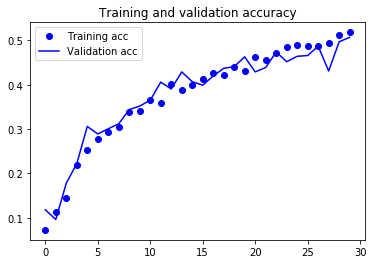

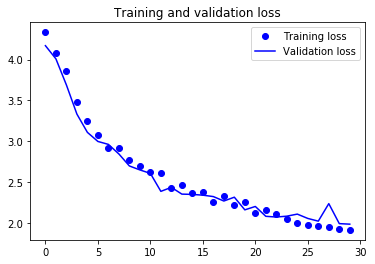

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
print(history.history.keys())

In [0]:
model1.evaluate(test_generator, y = ytestenc, batch_size=384, verbose=1)

In [0]:
print(test_dir)
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        classes=None,
        class_mode=None)


C:/git/pythonML/pythonML/notebooks/kaggle/plankton/test1
Found 7 images belonging to 1 classes.


In [0]:
from keras.models import load_model
saved_model = load_model('plankton_1.h5')

In [0]:
import numpy as np
res = saved_model.predict_generator(test_generator)
print(type(res))
print('test loss:', res[0:7][:])


<class 'numpy.ndarray'>
test loss: [[1.55043823e-03 2.87327282e-07 2.54275714e-04 4.30443033e-04
  1.87539961e-04 6.98763970e-03 2.24992186e-02 1.30681563e-02
  1.38394197e-03 1.09192915e-03 5.33830188e-03 5.02402857e-02
  2.09511686e-02 2.93081248e-04 1.78189052e-03 6.36992190e-05
  1.15064508e-03 2.86887574e-04 3.75655363e-05 1.58194394e-03
  9.16242352e-05 7.47224913e-05 9.94460715e-05 8.83669185e-04
  2.04014083e-04 2.20756410e-04 1.47524615e-05 3.29790782e-04
  1.28330877e-02 8.69486481e-04 4.21362603e-03 3.48874019e-04
  1.04676734e-03 4.58877441e-03 7.68225593e-03 3.04203723e-02
  3.81902355e-05 9.70868801e-04 2.05401157e-04 7.12346111e-04
  4.78941402e-05 2.37662112e-03 2.66697677e-03 1.88318714e-02
  9.68604535e-03 2.88929266e-04 6.74671464e-05 2.75421771e-04
  2.01660136e-04 3.39233503e-02 2.44026214e-05 6.24845969e-04
  2.61080102e-04 2.68096046e-04 2.25272146e-04 1.65731362e-05
  4.42098417e-06 4.48625209e-03 3.56107834e-03 1.52817345e-03
  1.04081025e-02 3.74380556e-06 1.5

In [0]:
len(test_generator.filenames)

7

In [0]:
saved_model.metrics_names

['loss', 'acc']

In [0]:
train_generator.class_indices['acantharia_protist']

0

In [0]:
train_generator.class_indices

{'acantharia_protist': 0,
 'acantharia_protist_big_center': 1,
 'acantharia_protist_halo': 2,
 'amphipods': 3,
 'appendicularian_fritillaridae': 4,
 'appendicularian_s_shape': 5,
 'appendicularian_slight_curve': 6,
 'appendicularian_straight': 7,
 'artifacts': 8,
 'artifacts_edge': 9,
 'chaetognath_non_sagitta': 10,
 'chaetognath_other': 11,
 'chaetognath_sagitta': 12,
 'chordate_type1': 13,
 'copepod_calanoid': 14,
 'copepod_calanoid_eggs': 15,
 'copepod_calanoid_eucalanus': 16,
 'copepod_calanoid_flatheads': 17,
 'copepod_calanoid_frillyAntennae': 18,
 'copepod_calanoid_large': 19,
 'copepod_calanoid_large_side_antennatucked': 20,
 'copepod_calanoid_octomoms': 21,
 'copepod_calanoid_small_longantennae': 22,
 'copepod_cyclopoid_copilia': 23,
 'copepod_cyclopoid_oithona': 24,
 'copepod_cyclopoid_oithona_eggs': 25,
 'copepod_other': 26,
 'crustacean_other': 27,
 'ctenophore_cestid': 28,
 'ctenophore_cydippid_no_tentacles': 29,
 'ctenophore_cydippid_tentacles': 30,
 'ctenophore_lobate': 

In [0]:
res[0][train_generator.class_indices['acantharia_protist']]

0.0015504382

In [0]:
[*train_generator.class_indices]

['acantharia_protist',
 'acantharia_protist_big_center',
 'acantharia_protist_halo',
 'amphipods',
 'appendicularian_fritillaridae',
 'appendicularian_s_shape',
 'appendicularian_slight_curve',
 'appendicularian_straight',
 'artifacts',
 'artifacts_edge',
 'chaetognath_non_sagitta',
 'chaetognath_other',
 'chaetognath_sagitta',
 'chordate_type1',
 'copepod_calanoid',
 'copepod_calanoid_eggs',
 'copepod_calanoid_eucalanus',
 'copepod_calanoid_flatheads',
 'copepod_calanoid_frillyAntennae',
 'copepod_calanoid_large',
 'copepod_calanoid_large_side_antennatucked',
 'copepod_calanoid_octomoms',
 'copepod_calanoid_small_longantennae',
 'copepod_cyclopoid_copilia',
 'copepod_cyclopoid_oithona',
 'copepod_cyclopoid_oithona_eggs',
 'copepod_other',
 'crustacean_other',
 'ctenophore_cestid',
 'ctenophore_cydippid_no_tentacles',
 'ctenophore_cydippid_tentacles',
 'ctenophore_lobate',
 'decapods',
 'detritus_blob',
 'detritus_filamentous',
 'detritus_other',
 'diatom_chain_string',
 'diatom_chain_

In [0]:
list(train_generator.class_indices.values())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120]

In [0]:
import pandas as pd
result = pd.read_csv('D:\data\kaggle\datasciencebowl\sampe.csv')
result

,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
1,10.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
2,100.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
3,1000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
4,10000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
5,100000.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
6,100001.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
7,100002.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
8,100003.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264
9,100004.jpg,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,...,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264,0.008264


In [0]:
result.iloc[0]['acantharia_protist_big_center']

0.00826446

In [0]:

result.loc[0, 'acantharia_protist_big_center'] = res[0][train_generator.class_indices['acantharia_protist']]

In [0]:
result.iloc[0]['acantharia_protist_big_center']

0.0015504382317885756

In [0]:
for i in range(0,len(test_generator.filenames)):
    for c in result.columns[result.columns != 'image']:
       result.loc[i, c] = res[i][train_generator.class_indices[c]]

In [0]:
df = pd.DataFrame(data=res, columns=[*train_generator.class_indices])
df['image'] = test_generator.filenames
df.to_csv("result.csv", encoding='utf-8')
df

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified,image
0,1.550438e-03,2.873273e-07,2.542757e-04,4.304430e-04,1.875400e-04,0.006988,0.022499,0.013068,1.383942e-03,1.091929e-03,...,3.926658e-05,0.015319,0.029847,4.488757e-03,6.505976e-03,1.276075e-03,5.376742e-03,1.018125e-03,0.036265,test\1.jpg
1,4.404555e-08,3.671397e-14,3.260657e-08,6.984881e-09,2.120076e-11,0.000004,0.000036,0.000004,3.179397e-06,3.910919e-06,...,3.275468e-11,0.000112,0.000053,1.274427e-04,3.160818e-05,9.427491e-07,1.711290e-07,1.361928e-07,0.000057,test\10.jpg
2,3.575065e-02,2.657032e-07,3.519067e-04,2.333441e-05,1.350978e-05,0.007433,0.008314,0.000749,5.887065e-04,6.667691e-05,...,2.632434e-06,0.000412,0.000098,8.696159e-07,1.381468e-06,3.222523e-07,1.417227e-02,8.029834e-03,0.003192,test\100.jpg
3,7.375186e-02,8.939671e-07,8.656372e-03,4.290618e-05,1.896226e-05,0.005262,0.009417,0.005543,6.392824e-02,1.480947e-02,...,4.061563e-05,0.003126,0.000790,3.375095e-05,1.440551e-05,1.080211e-05,1.587330e-02,2.817073e-02,0.015480,test\1000.jpg
4,2.469796e-02,2.432375e-09,5.245298e-04,4.363586e-05,1.940766e-06,0.024291,0.036124,0.001264,5.396080e-05,4.005541e-06,...,3.192369e-06,0.001677,0.001007,8.107447e-07,2.059443e-06,1.428344e-05,2.127241e-02,5.131537e-02,0.005687,test\10000.jpg
5,1.780102e-07,5.557872e-13,9.953635e-08,1.176120e-04,1.131654e-09,0.000010,0.000046,0.000002,5.845316e-08,2.969839e-07,...,3.957938e-08,0.000153,0.000022,8.639088e-10,9.603356e-07,1.770288e-09,9.049373e-02,5.004635e-06,0.001039,test\100000.jpg
6,1.984030e-03,1.052086e-06,2.564936e-03,3.313964e-04,3.771342e-04,0.019236,0.022538,0.016385,1.665646e-04,4.487879e-04,...,2.370291e-04,0.031311,0.044418,5.857598e-04,1.089649e-02,1.394714e-03,6.828749e-03,6.704599e-03,0.041377,test\100001.jpg


,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,2.873273e-07,2.542757e-04,1.550438e-03,4.304430e-04,1.875400e-04,0.006988,0.022499,0.013068,1.091929e-03,...,9.944480e-04,3.926658e-05,0.029847,0.015319,4.488757e-03,1.276075e-03,6.505976e-03,5.376742e-03,1.018125e-03,0.036265
1,10.jpg,3.671397e-14,3.260657e-08,4.404555e-08,6.984881e-09,2.120076e-11,0.000004,0.000036,0.000004,3.910919e-06,...,1.173726e-07,3.275468e-11,0.000053,0.000112,1.274427e-04,9.427491e-07,3.160818e-05,1.711290e-07,1.361928e-07,0.000057
2,100.jpg,2.657032e-07,3.519067e-04,3.575065e-02,2.333441e-05,1.350978e-05,0.007433,0.008314,0.000749,6.667691e-05,...,1.543624e-02,2.632434e-06,0.000098,0.000412,8.696159e-07,3.222523e-07,1.381468e-06,1.417227e-02,8.029834e-03,0.003192
3,1000.jpg,8.939671e-07,8.656372e-03,7.375186e-02,4.290618e-05,1.896226e-05,0.005262,0.009417,0.005543,1.480947e-02,...,3.467557e-03,4.061563e-05,0.000790,0.003126,3.375095e-05,1.080211e-05,1.440551e-05,1.587330e-02,2.817073e-02,0.015480
4,10000.jpg,2.432375e-09,5.245298e-04,2.469796e-02,4.363586e-05,1.940766e-06,0.024291,0.036124,0.001264,4.005541e-06,...,9.910951e-03,3.192369e-06,0.001007,0.001677,8.107447e-07,1.428344e-05,2.059443e-06,2.127241e-02,5.131537e-02,0.005687
5,100000.jpg,5.557872e-13,9.953635e-08,1.780102e-07,1.176120e-04,1.131654e-09,0.000010,0.000046,0.000002,2.969839e-07,...,8.788263e-05,3.957938e-08,0.000022,0.000153,8.639088e-10,1.770288e-09,9.603356e-07,9.049373e-02,5.004635e-06,0.001039
6,100001.jpg,1.052086e-06,2.564936e-03,1.984030e-03,3.313964e-04,3.771342e-04,0.019236,0.022538,0.016385,4.487879e-04,...,2.274007e-03,2.370291e-04,0.044418,0.031311,5.857598e-04,1.394714e-03,1.089649e-02,6.828749e-03,6.704599e-03,0.041377
7,100002.jpg,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264,0.008264,0.008264,8.264460e-03,...,8.264460e-03,8.264460e-03,0.008264,0.008264,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264
8,100003.jpg,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264,0.008264,0.008264,8.264460e-03,...,8.264460e-03,8.264460e-03,0.008264,0.008264,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264
9,100004.jpg,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264,0.008264,0.008264,8.264460e-03,...,8.264460e-03,8.264460e-03,0.008264,0.008264,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,8.264460e-03,0.008264
